In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### 1. 데이터 셋 준비하기
---

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

In [4]:
print(ds_info.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### input Normalization

In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255
    return image, label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

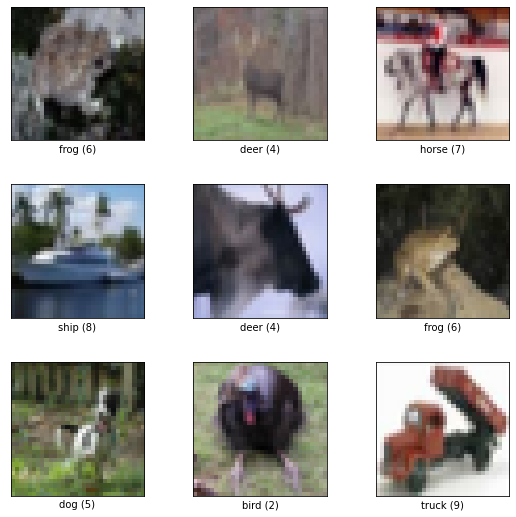

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

### 2. 블록 구성하기
---

### Conv Block

In [8]:
def conv_block(layer, channel, kernel_size, name, padding='same', strides=1, activation='relu'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x               

###  Residual Block

In [9]:
def residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_block(layer=x, 
                                      channel=channel*4, 
                                      kernel_size=(1,1),
                                      name=f'shortcut_{block_num}_{i}',
                                      strides=2,
                                      activation=None)
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1',  strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2', )
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3', activation=None)
            
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3', activation=None)
        x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
        x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
            
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_block(x, channel, (1,1), name=f'_shortcut_{block_num}_{i}', strides=2, activation=None)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1', strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2', activation=None)
            
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2', activation=None)
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    
    return x
                                        

### Plain Block

In [10]:
def plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1', strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_block(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_block(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1', strides=2)
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_block(x, channel, (3,3), name=f'{block_num}_{i}2')
    
    return x

### 3. ResNet 구현하기
---

In [11]:
def build_resnet(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=1, name='ResNet'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    conv1 = conv_block(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = residual_block(res, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

### ResNet-34

In [12]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                        channel_list=[64, 128, 256, 512],
                        is_50=False,
                        input_shape=(224, 224, 3),
                        name='ResNet_34')

resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### ResNet-50

In [13]:
resnet_50 = build_resnet(num_cnn_list=[3,4,6,3],
                        channel_list=[64,128,256,512],
                        is_50=True,
                        input_shape=(224,224,3),
                        name='ResNet_50')

resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### 4. ResNet 학습하기
---

### ResNet-30

In [14]:
BATCH_SIZE = 32
EPOCH = 16

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [16]:
ds_train

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [17]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                        channel_list=[64, 128, 256 ,512],
                        is_50=False,
                        input_shape=(224,224,3),
                        name='ResNet_34')

In [18]:

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=512,
    validation_steps=512,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
)

Epoch 1/16
  2/512 [..............................] - ETA: 35s - loss: 3.9233 - accuracy: 0.4531WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0546s vs `on_train_batch_end` time: 0.0854s). Check your callbacks.


512/512 [==============================] - 89s 174ms/step - loss: 0.8847 - accuracy: 0.5300 - val_loss: 0.7950 - val_accuracy: 0.5441
Epoch 2/16
512/512 [==============================] - 96s 187ms/step - loss: 0.6820 - accuracy: 0.5648 - val_loss: 0.6683 - val_accuracy: 0.5873
Epoch 3/16
512/512 [==============================] - 85s 165ms/step - loss: 0.6686 - accuracy: 0.5965 - val_loss: 0.6744 - val_accuracy: 0.5911
Epoch 4/16
512/512 [==============================] - 85s 165ms/step - loss: 0.6523 - accuracy: 0.6174 - val_loss: 0.6490 - val_accuracy: 0.6272
Epoch 5/16
512/512 [==============================] - 85s 165ms/step - loss: 0.6251 - accuracy: 0.6451 - val_loss: 0.7356 - val_accuracy: 0.5771
Epoch 6/16
512/512 [==============================] - 85s 165ms/step - loss: 0.6034 - accuracy: 0.6713 - val_loss: 1.0245 - val_accuracy: 0.5595
Epoch 7/16
512/512 [==============================] - 85s 165ms/step - loss: 0.5693 - accuracy: 0.6936 - val_loss: 0.5462 - val_accuracy: 0.7

In [19]:
resnet_50 = build_resnet(num_cnn_list=[3,4,6,3],
                        channel_list=[64,128,256,512],
                        is_50=True,
                        input_shape=(224,224,3),
                        name='ResNet_50')

In [ ]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy']
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=512,
    validation_steps=512,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
)

Epoch 1/16
512/512 [==============================] - 90s 176ms/step - loss: 0.8296 - accuracy: 0.5067 - val_loss: 0.6950 - val_accuracy: 0.5290
Epoch 2/16
512/512 [==============================] - 50s 98ms/step - loss: 0.6935 - accuracy: 0.5124 - val_loss: 0.7208 - val_accuracy: 0.4882
Epoch 3/16
512/512 [==============================] - 51s 99ms/step - loss: 0.6947 - accuracy: 0.4982 - val_loss: 0.6937 - val_accuracy: 0.4921
Epoch 4/16
512/512 [==============================] - 50s 98ms/step - loss: 0.6932 - accuracy: 0.5095 - val_loss: 0.6908 - val_accuracy: 0.5251
Epoch 5/16
512/512 [==============================] - 50s 99ms/step - loss: 0.6933 - accuracy: 0.5136 - val_loss: 0.6909 - val_accuracy: 0.5282
Epoch 6/16
512/512 [==============================] - 50s 99ms/step - loss: 0.6928 - accuracy: 0.5107 - val_loss: 0.6891 - val_accuracy: 0.5400
Epoch 7/16
512/512 [==============================] - 50s 99ms/step - loss: 0.6924 - accuracy: 0.5176 - val_loss: 0.6916 - val_accuracy

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'])
plt.show()

### Plain 과 비교하기
---

In [ ]:
def build_plain(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=1, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    conv1 = conv_block(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    output = keras.layers.Dense(1, activation='sigmoid', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

In [ ]:
plain_50 = build_plain(num_cnn_list=[3,4,6,3],
                      channel_list=[64,128,256,512],
                      is_50=True,
                      input_shape=(224,224,3))
plain_50.summary()

In [ ]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy'])

history_plain = plain_50.fit(
    ds_train,
    steps_per_epoch=512,
    validation_steps=512,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1
)